# **Project 3D Velodyne points to 2D camera Image** 
***

## Dataset
[KITTI 2011_09_26_drive_0005 dataset](http://www.cvlibs.net/datasets/kitti/raw_data.php?type=city)  
In this code, rectified image is used.

refer to [KITTI Dataset Paper](http://www.cvlibs.net/publications/Geiger2013IJRR.pdf) for the details of data measurement environment

## Objective

Project Velodyne points(model : HDL-64E) to 2D camera Image.  
  
  

<img src="objective.png">

# Process
  
***  

For converting coordinate systems, there are several steps.  
To help your understanding, I made a simple slide. The codes below are proceeding as these steps.
  
<img src="process.png">

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

def load_from_bin(bin_path):
    obj = np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)
    return obj

# bin file -> numpy array
velo_points = load_from_bin('./velodyne_points/data/0000000089.bin')

print(velo_points.shape)

(123749, 4)


(375, 1242, 3)


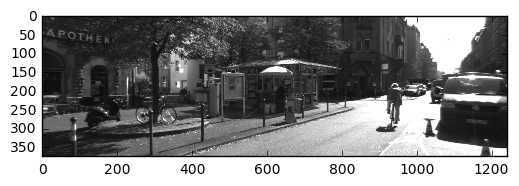

In [2]:
import matplotlib.image as mpimg

#read left camera image

image_type = 'grayscale' # 'grayscale' or 'color' image

mode = '00' if image_type == 'grayscale' else '02' 

image = cv2.imread('image_'+ mode +'/data/0000000089.png')
width, height = image.shape[1], image.shape[0]

plt.imshow(image)
print(image.shape)

In [3]:
def depth_color(val, min_d=0, max_d=120):
    """ 
    print Color(HSV's H value) corresponding to distance(m) 
    close distance = red , far distance = blue
    """
    np.clip(val, 0, max_d, out=val) # max distance is 120m but usually not usual
    return (((val - min_d) / (max_d - min_d)) * 120).astype(np.uint8) 

def in_h_range_points(points, m, n, fov):
    """ extract horizontal in-range points """
    return np.logical_and(np.arctan2(n,m) > (-fov[1] * np.pi / 180), \
                          np.arctan2(n,m) < (-fov[0] * np.pi / 180))

def in_v_range_points(points, m, n, fov):
    """ extract vertical in-range points """
    return np.logical_and(np.arctan2(n,m) < (fov[1] * np.pi / 180), \
                          np.arctan2(n,m) > (fov[0] * np.pi / 180))

def fov_setting(points, x, y, z, dist, h_fov, v_fov):
    """ filter points based on h,v FOV  """
    
    if h_fov[1] == 180 and h_fov[0] == -180 and v_fov[1] == 2.0 and v_fov[0] == -24.9:
        return points
    
    if h_fov[1] == 180 and h_fov[0] == -180:
        return points[in_v_range_points(points, dist, z, v_fov)]
    elif v_fov[1] == 2.0 and v_fov[0] == -24.9:        
        return points[in_h_range_points(points, x, y, h_fov)]
    else:
        h_points = in_h_range_points(points, x, y, h_fov)
        v_points = in_v_range_points(points, dist, z, v_fov)
        return points[np.logical_and(h_points, v_points)]

def in_range_points(points, size):
    """ extract in-range points """
    return np.logical_and(points > 0, points < size)    

def velo_points_filter(points, v_fov, h_fov):
    """ extract points corresponding to FOV setting """
    
    # Projecting to 2D
    x = points[:, 0]
    y = points[:, 1]
    z = points[:, 2]
    dist = np.sqrt(x ** 2 + y ** 2 + z ** 2)

    if h_fov[0] < -90:
        h_fov = (-90,) + h_fov[1:]
    if h_fov[1] > 90:
        h_fov = h_fov[:1] + (90,)
    
    x_lim = fov_setting(x, x, y, z, dist, h_fov, v_fov)
    y_lim = fov_setting(y, x, y, z, dist, h_fov, v_fov)
    z_lim = fov_setting(z, x, y, z, dist, h_fov, v_fov)
    
    # [:,] -> [:,1]
    x_lim = x_lim[:,None]
    y_lim = y_lim[:,None]
    z_lim = z_lim[:,None]
    
    # Stack arrays in sequence horizontally
    xyz_ = np.hstack((x_lim, y_lim,z_lim))
    xyz_ = xyz_.T

    # stack (1,n) arrays filled with the number 1
    one_mat = np.full((1, xyz_.shape[1]), 1)
    xyz_ = np.concatenate((xyz_, one_mat),axis = 0)

    # need dist info for points color
    dist_lim = fov_setting(dist, x, y, z, dist, h_fov, v_fov)
    color = depth_color(dist_lim, 0, 70)
    
    return xyz_, color

In [4]:
v2c_filepath = './calib_velo_to_cam.txt'
c2c_filepath = './calib_cam_to_cam.txt'

In [5]:
def calib_velo2cam(filepath):
    """ 
    get Rotation(R : 3x3), Translation(T : 3x1) matrix info 
    using R,T matrix, we can convert velodyne coordinates to camera coordinates
    """
    with open(filepath, "r") as f:
        file = f.readlines()    
        
        for line in file:
            (key, val) = line.split(':',1)
            if key == 'R':
                R = np.fromstring(val, sep=' ')
                R = R.reshape(3, 3)
            if key == 'T':
                T = np.fromstring(val, sep=' ')
                T = T.reshape(3, 1)
    return R, T

def calib_cam2cam(filepath, mode):
    """
    If your image is 'rectified image' :
        get only Projection(P : 3x4) matrix is enough
    but if your image is 'distorted image'(not rectified image) :
        you need undistortion step using distortion coefficients(5 : D)
        
    in this code, I'll get P matrix since I'm using rectified image
    """
    with open(filepath, "r") as f:
        file = f.readlines()
        
        for line in file:
            (key, val) = line.split(':',1)
            if key == ('P_rect_' + mode):
                P_ = np.fromstring(val, sep=' ')
                P_ = P_.reshape(3, 4)
                # erase 4th column ([0,0,0])
                P_ = P_[:3, :3]
    return P_
 
def velo3d_2_camera2d_points(points, v_fov, h_fov, vc_path, cc_path, mode='02'):
    """ print velodyne 3D points corresponding to camera 2D image """
    
    # R_vc = Rotation matrix ( velodyne -> camera )
    # T_vc = Translation matrix ( velodyne -> camera )
    R_vc, T_vc = calib_velo2cam(vc_path)
    
    # P_ = Projection matrix ( camera coordinates 3d points -> image plane 2d points )
    P_ = calib_cam2cam(cc_path, mode)

    """
    xyz_v - 3D velodyne points corresponding to h, v FOV in the velodyne coordinates
    c_    - color value(HSV's Hue) corresponding to distance(m)
    
             [x_1 , x_2 , .. ]
    xyz_v =  [y_1 , y_2 , .. ]   
             [z_1 , z_2 , .. ]
             [ 1  ,  1  , .. ]
    """  
    xyz_v, c_ = velo_points_filter(points, v_fov, h_fov)
    
    """
    RT_ - rotation matrix & translation matrix
        ( velodyne coordinates -> camera coordinates )
    
            [r_11 , r_12 , r_13 , t_x ]
    RT_  =  [r_21 , r_22 , r_23 , t_y ]   
            [r_31 , r_32 , r_33 , t_z ]
    """
    RT_ = np.concatenate((R_vc, T_vc),axis = 1)
    
    # convert velodyne coordinates(X_v, Y_v, Z_v) to camera coordinates(X_c, Y_c, Z_c) 
    for i in range(xyz_v.shape[1]):
        xyz_v[:3,i] = np.matmul(RT_, xyz_v[:,i])
        
    """
    xyz_c - 3D velodyne points corresponding to h, v FOV in the camera coordinates
             [x_1 , x_2 , .. ]
    xyz_c =  [y_1 , y_2 , .. ]   
             [z_1 , z_2 , .. ]
    """ 
    xyz_c = np.delete(xyz_v, 3, axis=0)

    # convert camera coordinates(X_c, Y_c, Z_c) image(pixel) coordinates(x,y) 
    for i in range(xyz_c.shape[1]):
        xyz_c[:,i] = np.matmul(P_, xyz_c[:,i])    

    """
    xy_i - 3D velodyne points corresponding to h, v FOV in the image(pixel) coordinates before scale adjustment
    ans  - 3D velodyne points corresponding to h, v FOV in the image(pixel) coordinates
             [s_1*x_1 , s_2*x_2 , .. ]
    xy_i =   [s_1*y_1 , s_2*y_2 , .. ]        ans =   [x_1 , x_2 , .. ]  
             [  s_1   ,   s_2   , .. ]                [y_1 , y_2 , .. ]
    """
    xy_i = xyz_c[::]/xyz_c[::][2]
    ans = np.delete(xy_i, 2, axis=0)
    
    """
    width = 1242
    height = 375
    w_range = in_range_points(ans[0], width)
    h_range = in_range_points(ans[1], height)

    ans_x = ans[0][np.logical_and(w_range,h_range)][:,None].T
    ans_y = ans[1][np.logical_and(w_range,h_range)][:,None].T
    c_ = c_[np.logical_and(w_range,h_range)]

    ans = np.vstack((ans_x, ans_y))
    """
    
    return ans, c_

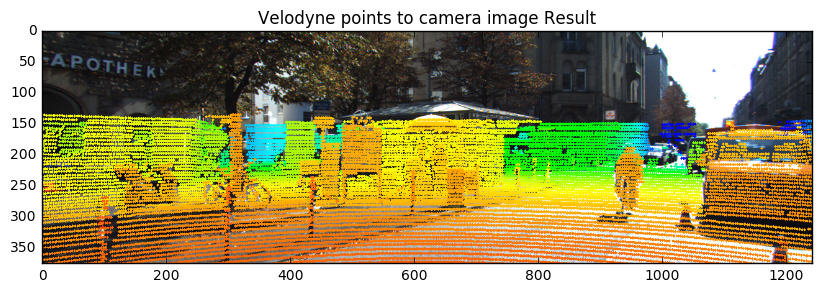

In [6]:
def print_projection_cv2(points, color, image):
    """ project converted velodyne points into camera image """
    
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    for i in range(ans.shape[1]):
        cv2.circle(hsv_image, (int(ans[0][i]),int(ans[1][i])),2, (int(c_[i]),255,255),-1)

    return cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)

def print_projection_plt(points, color, image):
    """ project converted velodyne points into camera image """
    
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    for i in range(ans.shape[1]):
        cv2.circle(hsv_image, (int(ans[0][i]),int(ans[1][i])),2, (int(c_[i]),255,255),-1)

    return cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)

image_type = 'color' # 'grayscale' or 'color' image
mode = '00' if image_type == 'grayscale' else '02' # image_00 = 'grayscale image' , image_02 = 'color image'

image = cv2.imread('image_'+ mode +'/data/0000000089.png')

ans, c_ = velo3d_2_camera2d_points(velo_points, v_fov=(-24.9, 2.0), h_fov=(-180,180), \
                               vc_path=v2c_filepath, cc_path=c2c_filepath, mode=mode)

image = print_projection_plt(points=ans, color=c_, image=image)

# display result image
plt.subplots(1,1, figsize = (13,3) )
plt.title("Velodyne points to camera image Result")
plt.imshow(image)


## Save Video

In [7]:
import glob
import cv2

image_type = 'color' # 'grayscale' or 'color' image
mode = '00' if image_type == 'grayscale' else '02' # image_00 = 'grayscale image' , image_02 = 'color image'

lidar_points = glob.glob('./velodyne_points/data/*.bin')
image = glob.glob('./image_' + mode + '/data/*.png')

""" save result video """
fourcc = cv2.VideoWriter_fourcc(*'XVID')
vid = cv2.VideoWriter('projection.mp4', fourcc, 25.0, (width, height))

for i, point in enumerate (lidar_points):
    velo = load_from_bin(point)

    img = cv2.imread(str(image[i]))

    ans, c_ = velo3d_2_camera2d_points(velo, v_fov=(-24.9, 2.0), h_fov=(-50,50), \
                                       vc_path=v2c_filepath, cc_path=c2c_filepath, mode=mode)
    
    img = print_projection_cv2(points=ans, color=c_, image=img)
    vid.write(img)

print('video saved')
vid.release()   

video saved


## Display Result Video

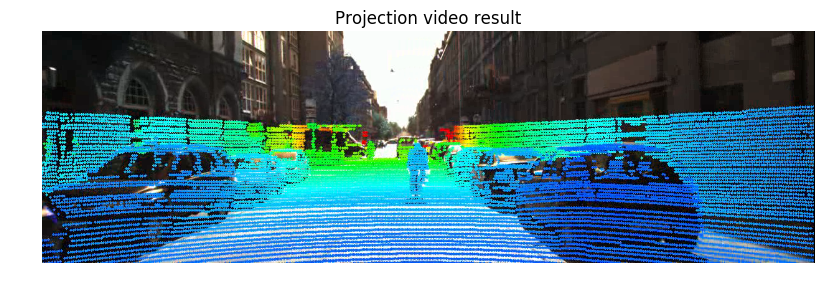

In [8]:
from IPython.display import clear_output

""" display video """
vid = cv2.VideoCapture("./projection.mp4")

while(True):
    ret, frame = vid.read()
    if not ret:
        vid.release()
        break
    fig = plt.figure(figsize=(12,3))
    
    plt.title("Projection video result")
    plt.axis('off')
    plt.imshow(frame)
    plt.show()
    # clear current frame for next frame
    clear_output(wait=True)

vid.release()